# Main working file

In [3]:
# imports

## system
import glob
import os
import numpy as np
import pandas as pd


import util.feature_extraction as fe
import util.feature_selection as fs
import util.correlation_measure as cm
import util.video_transformation as vt

from scipy.stats import pearsonr


LOCATION = "data"
ACTION_UNITS = "au"
FEATURE_FOLDER = "features"
CORRELATION_FOLDER = 'correlations'
PHASES = [f'{name}_{i}' for name, num in  [("instructional_video", 1), ("discussion_phase", 2)] for i in range(num)]#, ("reschu_run", 8)] for i in range(num)]
SETS = ['corrca', 'factors']
FACTORS = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']

for pair in os.listdir(LOCATION):
    filename = os.path.join(LOCATION, pair, FEATURE_FOLDER)
    os.makedirs(filename, exist_ok=True)
    filename = os.path.join(LOCATION, pair, CORRELATION_FOLDER)
    os.makedirs(filename, exist_ok=True)


# Preprocessing

## Rewrapping

In [5]:
# # Import the function
# from util.video_transformation import rewrap_video

# %load_ext autoreload
# %autoreload 2 

# base_path = "data-in"
# input_folder = "avi"

# for team_folder in os.listdir(base_path):
#     if team_folder not in ['09_10', '21_22']:
#         continue
#     path_videos = os.path.join(base_path, team_folder, input_folder, "*.avi")
#     files = glob.glob(path_videos)

#     for file in files:
#         rewrap_video(file, os.path.join(base_path, team_folder))

## Merge audio and video

In [6]:
# from util.video_transformation import merge_audio_video

# video_path = r'C:\Users\bruinj\OneDrive - TNO\Project Pages\Team Metrics\Team\Work\Experiment\data\21_22\analysis\pp21_navigator_reconstructed_video_2.avi'
# audio_path = r'C:\Users\bruinj\OneDrive - TNO\Project Pages\Team Metrics\Team\Work\Experiment\data\21_22\analysis\navigator_21_discussion_phase_1_audio.wav'
# output_path = r'C:\Users\bruinj\OneDrive - TNO\Project Pages\Team Metrics\Team\Work\Experiment\data\21_22\analysis\navigator_21_discussion_phase_1_audio_vid.avi'

# merge_audio_video()

# Extraction of Action Units (AUs)

In [7]:
# ### all in one doc:
# import util.feature_extraction as fe
# import os

# openface_path = r"C:\Users\Erik\Documents\facial-expression-synchrony\OpenFace_2.2.0_win_x64\OpenFace_2.2.0_win_x64\OpenFace_2.2.0_win_x64\FeatureExtraction.exe"
  
# data_in = r"data"
# data_out = r"data-out"
# folder = "au"
# phases = [("instructional_video", 1), ("discussion_phase", 2), ("reschu_run", 8)]
# for i in range(5,100)[::2]:
#     j = i + 1
#     if i < 10: i = "0" + str(i)
#     if j < 10: j = "0" + str(j)
#     pair = f"{i}_{j}"
#     print(pair)
#     for phase, count in phases:
#         for c in range(count):
#             nav = f"pp{i}_navigator_{phase}_{c}"
#             pil = f"pp{j}_pilot_{phase}_{c}"
#             for participant in [nav, pil]:
#                 input = os.path.join(data_in, participant + "_reconstructed_video.avi")
#                 output = os.path.join(data_out, pair, folder, participant + ".csv")
#                 if os.path.exists(input):
#                     if os.path.exists(output):
#                         print(f"{participant} already processed, skipping")
#                         continue
#                     else:
#                         print(f"{participant} extraction")
#                         os.system(f"{openface_path} -f \"{input}\" -aus -of \"{output}\"")
#                 else:
#                     print(f"{participant} avi file does not exist in the input folder")


In [8]:
### FOLLOWING OLD STRUCTURE
# from util.feature_extraction import extract_features
# data_in = r'data-in'
# data_out = r'data-out'

# for pair in os.listdir(data_in):
#     if pair == "21_22":
#         continue
#     input_folder = os.path.join(data_in, pair)
#     output_folder = os.path.join(data_out, pair, 'au')
#     for participant in pair.split('_'):
#         # TODO: handle missing data (NaN or recovered)
#         if os.path.exists(input_folder):
#             aus = extract_features(input_folder, participant, output_folder)


# Feature selection


## Facial factors

In [8]:
## EXTRACTING FACIAL FACTORS FOR EACH FILE SEPARATELY
for pair in os.listdir(LOCATION):
    if pair in ['07_08', '09_10']:
        for file in os.listdir(os.path.join(LOCATION, pair, ACTION_UNITS)):
            if ".csv" in file and 'Data' not in file: 
                filename = os.path.join(LOCATION, pair, ACTION_UNITS, file)
                participant, _ = file.split("_",1)
                df = pd.read_csv(filename)
                for name in PHASES:
                    if name in file:
                        factors = fs.au_to_factors(df)
                        factors.to_csv(os.path.join(LOCATION, pair, FEATURE_FOLDER, f"{participant}_{name}_factors.csv"), index=False)

## Correlated Component Analysis

In [9]:
## CREATING WEIGHTS FOR EACH PAIR SEPARATELY

# corrCA takes a df as input. This df should be all files for a pair. 
for pair in os.listdir(LOCATION):
    if pair in ['07_08', '09_10']:
        filename = os.path.join(LOCATION, pair)
        data = {}
        nav, pil = pair.split("_")
        nav_df = pd.DataFrame()
        pil_df = pd.DataFrame()
        # add all phases to a single dataframe
        for file in os.listdir(os.path.join(filename, ACTION_UNITS)):
            if ".csv" in file and 'Data' not in file: 
                df = pd.read_csv(os.path.join(filename, ACTION_UNITS, file))
                if ".csv" in file and nav in file:
                    nav_df = pd.concat([nav_df, df])
                if ".csv" in file and pil in file:
                    pil_df = pd.concat([pil_df, df])
        nav_df, pil_df = fs.make_equal_length(pair, nav_df, pil_df)
        # Ensure DataFrames are aligned and have the same length
        mask = (nav_df.isna().any(axis=1).values) | (pil_df.isna().any(axis=1).values)
        nav_df = nav_df[~mask].reset_index(drop=True)
        pil_df = pil_df[~mask].reset_index(drop=True)

        w = fs.corrCA_weights(nav_df, pil_df, number_of_components=3) #output = pair/pair_corrca_weights.csv
        w.to_csv(os.path.join(filename, f"{pair}_corrca_weights.csv"), index=False)


files of pairs in 07_08 do not have the same amount of datapoints - temporary fix has made them equal length
(17, 17)
files of pairs in 09_10 do not have the same amount of datapoints - temporary fix has made them equal length
(17, 17)


In [10]:
## APPLYING CORRCA WEIGHTS TO EACH FILE SEPARATELY

for pair in os.listdir(LOCATION):
    loc = os.path.join(LOCATION, pair, f'{pair}_corrca_weights.csv')
    if not os.path.exists(loc):
        break
    w = pd.read_csv(os.path.join(LOCATION, pair, f'{pair}_corrca_weights.csv'))
    for file in os.listdir(os.path.join(LOCATION, pair, ACTION_UNITS)):
        if ".csv" in file and 'Data' not in file:  
            filename = os.path.join(LOCATION, pair, ACTION_UNITS, file)
            participant, _ = file.split("_", 1)
            df = pd.read_csv(filename)
            for name in PHASES:
                if name in file:
                    corrca = fs.apply_corrCA_weights(df, w)
                    corrca.to_csv(os.path.join(LOCATION, pair, FEATURE_FOLDER, f"{participant}_{name}_corrca.csv"), index=False)
                    continue


# Correlation measure

In [ ]:
# # make the factors and corrca components binary 
# # scale them to -1, 1

# df = pd.read_csv(r"C:\Users\Erik\Documents\facial-expression-synchrony\data-out\05_06\selection\pp05_discussion_phase_0_factors.csv")
# df = df.drop(columns=['frame'])

# print(df.values[:3])


# df = cm.binarize_components(df.values)
# print(df[:3])


## Pearson


In [3]:
# extract pearson correlation for each file for both facial factors and corrca features
for pair in os.listdir(LOCATION):
    df = pd.DataFrame()
    nav, pil = pair.split("_")
    file = os.path.join(LOCATION, pair, FEATURE_FOLDER)

    for phase in PHASES:
        correlation = []

        for condition in SETS:
            # do not process if it does not exists
            nav_file = os.path.join(os.path.join(file, f"pp{nav}_{phase}_{condition}.csv"))
            pil_file = os.path.join(os.path.join(file, f"pp{pil}_{phase}_{condition}.csv"))
            if not os.path.exists(nav_file) or not os.path.exists(pil_file):
                print(f"{pair}_{phase}_{condition} misses files, skipping entire {phase} for {pair}")
                break

            # process
            nav_df = pd.read_csv(nav_file)
            pil_df = pd.read_csv(pil_file)
            nav_df, pil_df = fs.make_equal_length(f"{pair}_{phase}", nav_df, pil_df)
            for i in range(1,nav_df.shape[1]):
                corr, _ = pearsonr(nav_df[f'f{i}'].values, pil_df[f'f{i}'].values)
                correlation.append(corr)
        if correlation: 
            df[phase] = correlation

    # for participant-wise saving
    df.to_csv(os.path.join(LOCATION, pair, CORRELATION_FOLDER, f"{pair}_pearson.csv"))
    
    # for easy access saving
    df.to_csv(os.path.join("results", f"{pair}_pearson.csv"))

# SETS = ['corrca', 'factors']
# PHASES = ['instructional_video_0', 'discussion_phase_0', 'discussion_phase_1']
# factors = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']

# # each pair gets a separate file
# for pair in os.listdir(LOCATION):
#     df = pd.DataFrame()
#     nav, pil = pair.split("_")
#     file = os.path.join(LOCATION, pair, CORRELATION_FOLDER)

#     # format:  | factor1 | factor2 | ... | factor 6 | corrca | (per phase)
#     for phase in PHASES:
#         correlation = []
#         # factors
#         nav_factors = pd.read_csv(os.path.join(file, f"pp{nav}_{phase}_factors.csv"))
#         pil_factors = pd.read_csv(os.path.join(file, f"pp{pil}_{phase}_factors.csv"))
#         nav_factors, pil_factors = fs.make_equal_length(f"{pair}_{phase}", nav_factors, pil_factors)
#         for f in factors:
#             corr, _ = pearsonr(nav_factors[f].values, pil_factors[f].values)
#             correlation.append(corr)

#         # corrca
#         nav_corrca = pd.read_csv(os.path.join(file, f"pp{nav}_{phase}_corrca.csv"))
#         pil_corrca = pd.read_csv(os.path.join(file, f"pp{pil}_{phase}_corrca.csv"))
#         nav_corrca, pil_corrca = fs.make_equal_length(f"{pair}_{phase}", nav_corrca, pil_corrca)
        
#         corr, _ = pearsonr(nav_corrca['component1'].values, pil_corrca['component1'].values)
#         correlation.append(corr)
        
#         df[phase] = correlation
    
#     # for participant-wise saving
#     df.to_csv(os.path.join(LOCATION, pair, "extraction", f"{pair}_pearson.csv"))
    
#     # for easy access saving
#     df.to_csv(os.path.join("results", f"{pair}_pearson.csv"))



files of pairs in 19_20_instructional_video_0 do not have the same amount of datapoints - temporary fix has made them equal length
files of pairs in 19_20_instructional_video_0 do not have the same amount of datapoints - temporary fix has made them equal length
files of pairs in 19_20_discussion_phase_0 do not have the same amount of datapoints - temporary fix has made them equal length
files of pairs in 19_20_discussion_phase_0 do not have the same amount of datapoints - temporary fix has made them equal length


## cRQA

array([2])

# EXPERIMENT AREA

Downsampling from 18838 to 3140 points
Normalized ranges - P1: [-5.44, 2.37]
Normalized ranges - P2: [-3.97, 6.45]
Radius: 1.0000, Current RR: 0.5366
Radius: 0.5050, Current RR: 0.2806
Radius: 0.2575, Current RR: 0.1449
Radius: 0.1338, Current RR: 0.0783
Radius: 0.0719, Current RR: 0.0411
Final radius: 0.0719
Max RR: 0.0502
Min RR: 0.0336


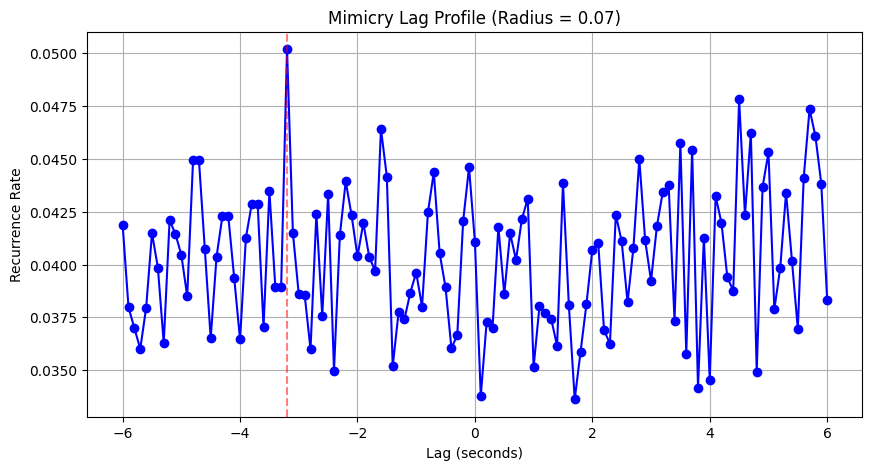

In [7]:
import pandas as pd
import util.feature_selection as fs
import util.correlation_measure as cm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

files1 = os.path.join(LOCATION, '07_08', FEATURE_FOLDER)
files2 = os.path.join(LOCATION, '09_10', FEATURE_FOLDER)
nav = pd.read_csv(os.path.join(files1, 'pp07_reschu_run_1_corrca.csv'))
pil = pd.read_csv(os.path.join(files1, 'pp08_reschu_run_1_corrca.csv'))

lags, rr_profile, radius = cm.crqa_lag_analysis(nav['f1'].values, pil['f1'].values, debug=True)


Downsampling from 18838 to 3140 points
Normalized ranges - P1: [-0.69, 8.47]
Normalized ranges - P2: [-2.90, 6.36]
Radius: 1.0000, Current RR: 0.6054
Radius: 0.5050, Current RR: 0.3408
Radius: 0.2575, Current RR: 0.1713
Radius: 0.1338, Current RR: 0.0834
Radius: 0.0719, Current RR: 0.0487
Final radius: 0.0719
Max RR: 0.0643
Min RR: 0.0401


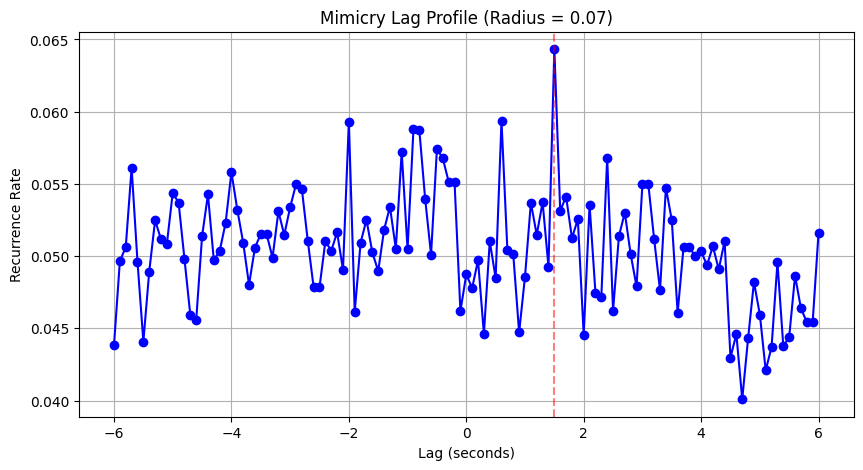

In [6]:
import pandas as pd
import util.feature_selection as fs
import util.correlation_measure as cm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

files1 = os.path.join(LOCATION, '07_08', FEATURE_FOLDER)
files2 = os.path.join(LOCATION, '09_10', FEATURE_FOLDER)
nav = pd.read_csv(os.path.join(files1, 'pp07_reschu_run_1_factors.csv'))
pil = pd.read_csv(os.path.join(files1, 'pp08_reschu_run_1_factors.csv'))

lags, rr_profile, radius = cm.crqa_lag_analysis(nav['f1'].values, pil['f1'].values, debug=True)



Downsampling from 18838 to 3140 points
Normalized ranges - P1: [-0.69, 8.47]
Normalized ranges - P2: [-0.31, 13.99]
Radius: 1.0000, Current RR: 0.8118
Radius: 0.5050, Current RR: 0.6554
Radius: 0.2575, Current RR: 0.3016
Radius: 0.1338, Current RR: 0.1449
Radius: 0.0719, Current RR: 0.0876
Radius: 0.0409, Current RR: 0.0468
Final radius: 0.0409
Max RR: 0.0505
Min RR: 0.0417


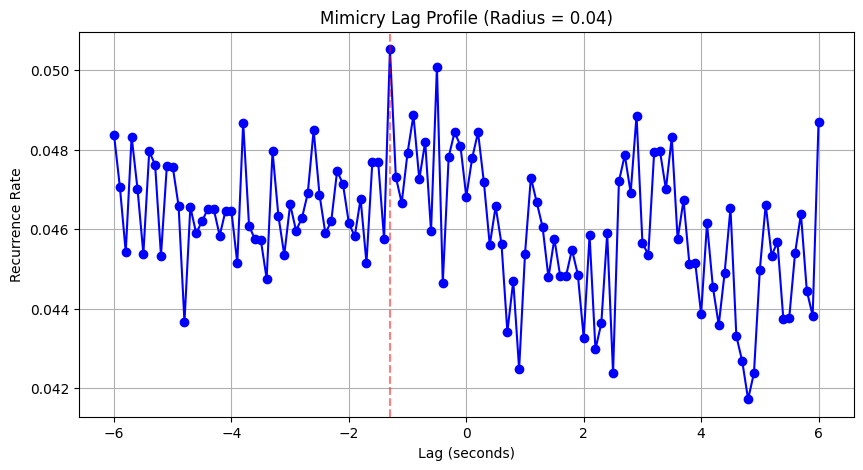

In [5]:
import pandas as pd
import util.feature_selection as fs
import util.correlation_measure as cm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

files1 = os.path.join(LOCATION, '07_08', FEATURE_FOLDER)
files2 = os.path.join(LOCATION, '09_10', FEATURE_FOLDER)
nav = pd.read_csv(os.path.join(files1, 'pp07_reschu_run_1_factors.csv'))
pil = pd.read_csv(os.path.join(files2, 'pp10_reschu_run_1_factors.csv'))

lags, rr_profile, radius = cm.crqa_lag_analysis(nav['f1'].values, pil['f1'].values, debug=True)


Downsampling from 18838 to 3140 points
Normalized ranges - P1: [-5.44, 2.37]
Normalized ranges - P2: [-10.46, 1.48]
Radius: 1.0000, Current RR: 0.6761
Radius: 0.5050, Current RR: 0.3981
Radius: 0.2575, Current RR: 0.2137
Radius: 0.1338, Current RR: 0.1159
Radius: 0.0719, Current RR: 0.0646
Radius: 0.0409, Current RR: 0.0376
Radius: 0.0564, Current RR: 0.0500
Final radius: 0.0564
Max RR: 0.0633
Min RR: 0.0390


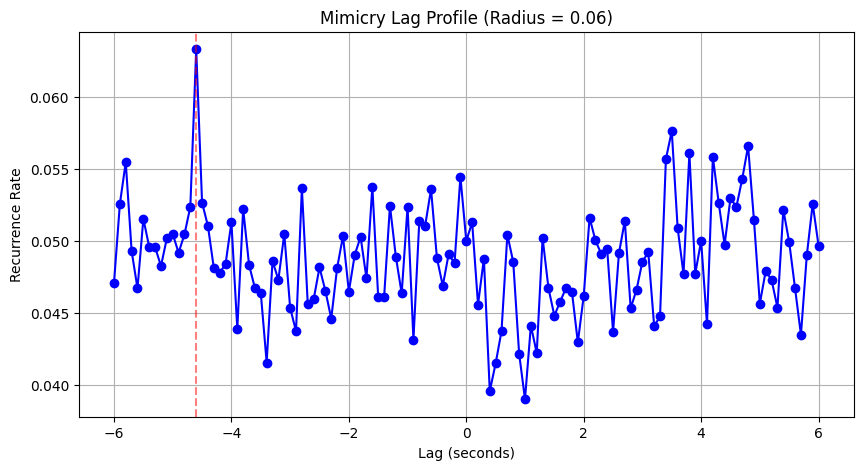

In [4]:
import pandas as pd
import util.feature_selection as fs
import util.correlation_measure as cm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

files1 = os.path.join(LOCATION, '07_08', FEATURE_FOLDER)
files2 = os.path.join(LOCATION, '09_10', FEATURE_FOLDER)
nav = pd.read_csv(os.path.join(files1, 'pp07_reschu_run_1_corrca.csv'))
pil = pd.read_csv(os.path.join(files2, 'pp10_reschu_run_1_corrca.csv'))

lags, rr_profile, radius = cm.crqa_lag_analysis(nav['f1'].values, pil['f1'].values, debug=True)

# Plot results
